## Fine tuning model to recognize opened or closed window
Use cases: check if windows are closed if raining or when leaving house


In [710]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
# libraries for displaying images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import math
from skimage import exposure

In [711]:
WIDTH = 224
HEIGHT = 224
NUM_CLASSES = 2
TRAIN_DATA_DIR = r"../contents/windows_imgs/train"
VAL_DATA_DIR = r"../contents/windows_imgs/val"
DATA_DIR = r"../contents/windows_imgs/data"
TEST_DATA_DIR = r"../contents/windows_imgs/test"
TRAIN_SAMPLES = 9
VAL_SAMPLES = 4
BATCH_SIZE = 32
EPOCH = 150
CLASS_THRESHOLD = 0.5
LEARNING_RATE = 0.001

### Prepare the data
load image data from directory and preprocess it

In [712]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,
    # width_shift_range = 0.3,
    # height_shift_range = 0.3,
    # zoom_range=0.2,
    # shear_range=0.2,
    # horizontal_flip=True,

)

val_datagen = ImageDataGenerator(rescale=1./255)

In [713]:

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 12345,
    class_mode = 'binary',
    save_to_dir=r"../contents/windows_imgs/output/train/",
    save_prefix="",
    save_format='jpg')
TRAIN_SAMPLES = train_generator.samples

val_generator = train_datagen.flow_from_directory(
    VAL_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = 'binary',
    save_to_dir=r"../contents/windows_imgs/output/val/",
    save_prefix="",
    save_format='jpg')
VAL_SAMPLES = val_generator.samples


Found 91 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


Code to show the augmented images

In [714]:
# # define the figure plot area
# # fig, ax = plt.subplots(1,NUM_IMG, figsize=(12,4))
# import matplotlib.pyplot as plt

# for i in range(BATCH_SIZE):
#     print(f'Run #{i}')
#     img, label = train_generator.next()
#     # classval = np.argmax(label[0], axis = 0)    # convert one-hot encoding to index
#     # classkey = find_key(classval, iter_img.class_indices) # get class key from index value
#     plt.imshow(img[0])
#     plt.show()
#     # print(f'img shape {img.shape}')
#     # print(f'img label {classkey}\n')

# plt.show()

In [715]:
# import cv2

# # cv2.waitKey(0)
# cam = cv2.VideoCapture(0)

# result, cam_img = cam.read()
# if result:
#     # cv2.imshow("Captured image", cam_img)
#     cv2.imwrite(TEST_DATA_DIR + r"\test_window.jpeg", cam_img)
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()
# else:
#     print("No image detected. Please try again.") 


# from sympy import plot


# img_path = r'../contents/windows_imgs/test/test_window.jpeg'
# img = image.load_img(img_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
# expanded_img_array = np.expand_dims(img_array, axis=0)
# preprocessed_img = expanded_img_array / 255.  # Preprocess the image
# prediction = model.predict(preprocessed_img)
# print(prediction)
# print(val_generator.class_indices)

# # plt.figure(1,1)
# plt.imshow(img)
# plt.show()

#### Load the pre-trained modfel and add in fine tuning layers
Now we define the model layers to freeze, discard to classification layers
then finally add in the fine tuning layers


In [716]:

def model_maker():
    # load model
    base_model = MobileNet(
        include_top=False,
        input_shape=(WIDTH, HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(WIDTH, HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(256, activation = 'sigmoid')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(1, activation='sigmoid')(custom_model)
    return Model(inputs=input, outputs=predictions)


In [717]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
# from tensorflow.keras.optimizers import SGD,RMSprop,adam

def model_maker_scratch():
    from_scratch = Sequential()
    from_scratch.add(Convolution2D(244, 3,3,input_shape=(WIDTH, HEIGHT, 3)))
    from_scratch.add(Activation('relu'))
    from_scratch.add(Convolution2D(244, 3, 3))
    from_scratch.add(Activation('relu'))
    from_scratch.add(MaxPooling2D(pool_size=(2, 2)))
    from_scratch.add(Dropout(0.25))
    # from_scratch.add(Convolution2D(64, 3, 3))
    from_scratch.add(Convolution2D(244, 3, 3))
    from_scratch.add(Activation('relu'))
    from_scratch.add(MaxPooling2D(pool_size=(2, 2)))
    from_scratch.add(Dropout(0.25))
    # 
    from_scratch.add(Flatten())
    from_scratch.add(Dense(128, activation='relu'))
    from_scratch.add(Dropout(0.5))
    from_scratch.add(Dense(1, activation='sigmoid'))
    # from_scratch.add(Dense(1))
    # from_scratch.add(Activation('sigmoid'))
    return(from_scratch)


In [718]:
# model = model_maker_scratch()
model = model_maker()

model.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=['acc'])

model.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience=3)



Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_73 (Dense)            (None, 256)               262400    
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 dense_74 (Dense)            (None, 1)                 257

In [719]:

from gc import callbacks


history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE),
    epochs=EPOCH,
    callbacks=[early_stopping],
    validation_data=val_generator,
    validation_steps=math.ceil(float(VAL_SAMPLES)/BATCH_SIZE))
    

Epoch 1/150
3/3 [==============================] - 7s 2s/step - loss: 0.7928 - acc: 0.5824 - val_loss: 0.6181 - val_acc: 0.7143
Epoch 2/150
3/3 [==============================] - 4s 1s/step - loss: 0.6652 - acc: 0.6044 - val_loss: 0.6103 - val_acc: 0.6667
Epoch 3/150
3/3 [==============================] - 4s 1s/step - loss: 0.6298 - acc: 0.6264 - val_loss: 0.6153 - val_acc: 0.6667
Epoch 4/150
3/3 [==============================] - 4s 2s/step - loss: 0.6146 - acc: 0.6374 - val_loss: 0.6047 - val_acc: 0.6667
Epoch 5/150
3/3 [==============================] - 4s 2s/step - loss: 0.5924 - acc: 0.6703 - val_loss: 0.5731 - val_acc: 0.7143
Epoch 6/150
3/3 [==============================] - 4s 1s/step - loss: 0.5964 - acc: 0.6923 - val_loss: 0.5647 - val_acc: 0.6667
Epoch 7/150
3/3 [==============================] - 4s 1s/step - loss: 0.5454 - acc: 0.7363 - val_loss: 0.6336 - val_acc: 0.6667
Epoch 8/150
3/3 [==============================] - 4s 1s/step - loss: 0.5799 - acc: 0.6923 - val_loss: 0

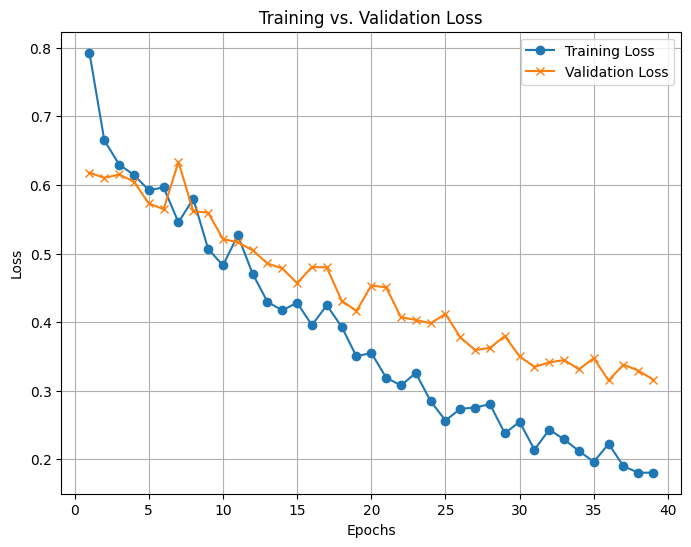

In [720]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' object with training and validation loss
# Example: history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

# Retrieve training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='x')

# Customize the plot
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [721]:
model.save('model.h5')

In [748]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = load_model('good_model.h5')

In [755]:
import cv2

# cv2.waitKey(0)
cam = cv2.VideoCapture(0)

result, cam_img = cam.read()
if result:
    
    # cv2.imshow("Captured image", cam_img)
    # equ_img = cv2.equalizeHist(cam_img)
    cv2.imwrite(TEST_DATA_DIR + r"\test_window.jpeg", cam_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
else:
    print("No image detected. Please try again.") 



1/1 [==============================] - 0s 41ms/step
[[0.5366465]]
{'close': 0, 'open': 1}


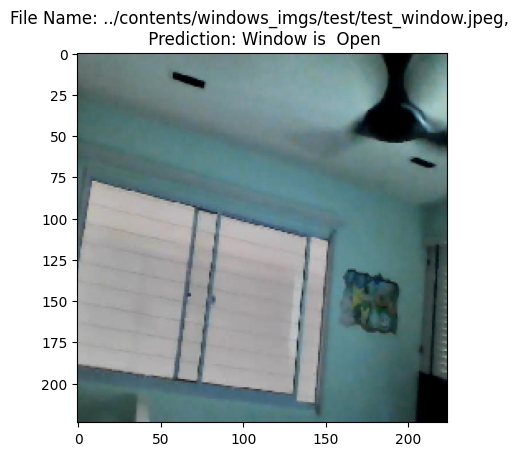

In [756]:
from skimage import exposure, transform
from skimage.io import imread

img_path = r'../contents/windows_imgs/test/test_window.jpeg'
img = image.load_img(img_path, target_size=(224, 224))

# img = imread(img_path)
# img = exposure.equalize_hist(img)
# new_shape = (224, 224)
# img = transform.resize(img, new_shape, anti_aliasing=True)

img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(val_generator.class_indices)

# plt.figure(1,1)
plt.title(f"File Name: {img_path}, \n Prediction: Window is  {'Close' if prediction < CLASS_THRESHOLD else 'Open'}")
plt.imshow(img)
plt.show()    


1/1 [==============================] - 0s 34ms/step
[[0.7451488]]
{'close': 0, 'open': 1}


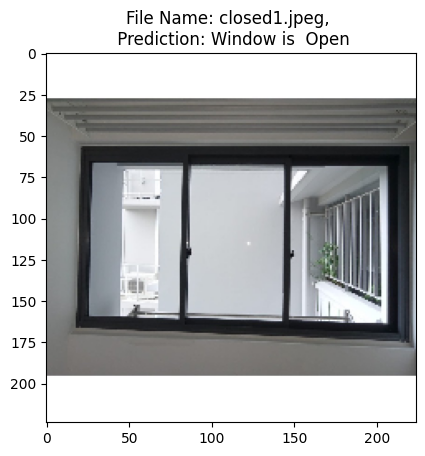

1/1 [==============================] - 0s 38ms/step
[[0.55391395]]
{'close': 0, 'open': 1}


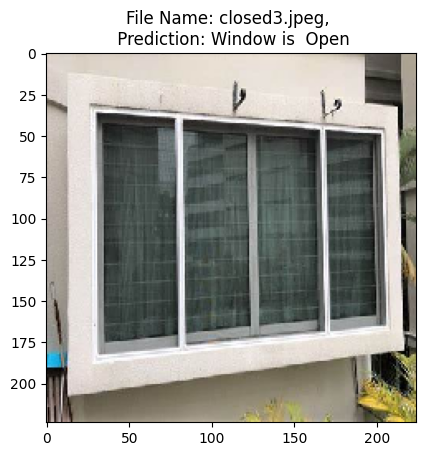

1/1 [==============================] - 0s 40ms/step
[[0.06608252]]
{'close': 0, 'open': 1}


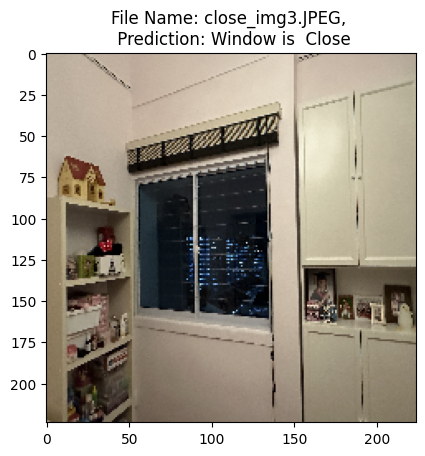

1/1 [==============================] - 0s 40ms/step
[[0.381683]]
{'close': 0, 'open': 1}


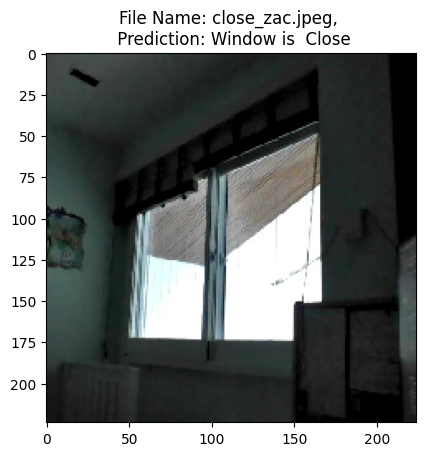

1/1 [==============================] - 0s 37ms/step
[[0.5624058]]
{'close': 0, 'open': 1}


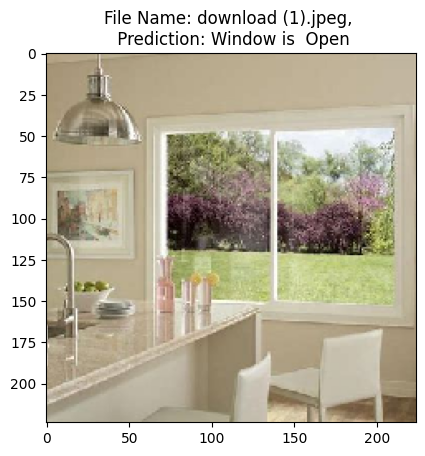

1/1 [==============================] - 0s 36ms/step
[[0.9434471]]
{'close': 0, 'open': 1}


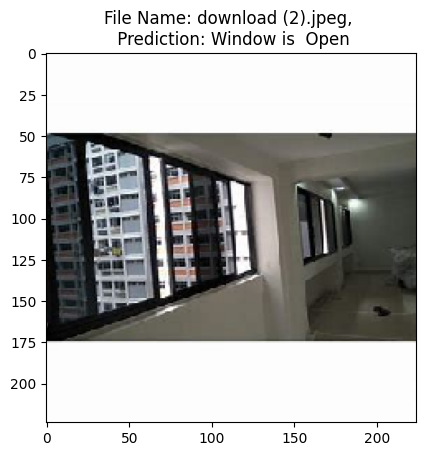

1/1 [==============================] - 0s 38ms/step
[[0.7299504]]
{'close': 0, 'open': 1}


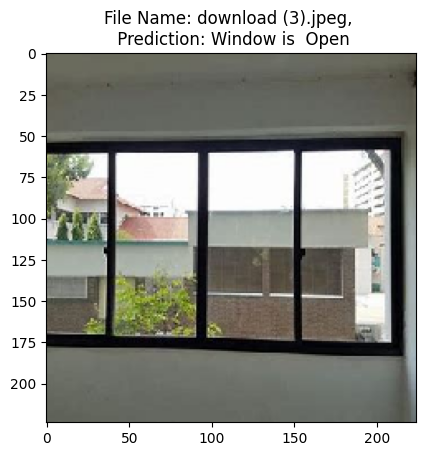

1/1 [==============================] - 0s 46ms/step
[[0.83540815]]
{'close': 0, 'open': 1}


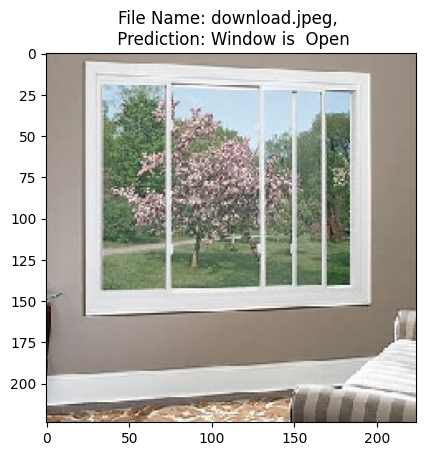

1/1 [==============================] - 0s 52ms/step
[[0.86424345]]
{'close': 0, 'open': 1}


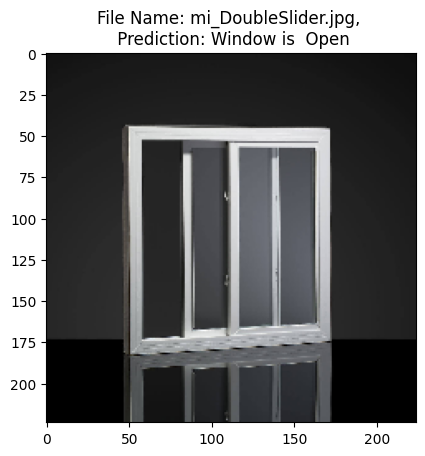

1/1 [==============================] - 0s 38ms/step
[[0.9970499]]
{'close': 0, 'open': 1}


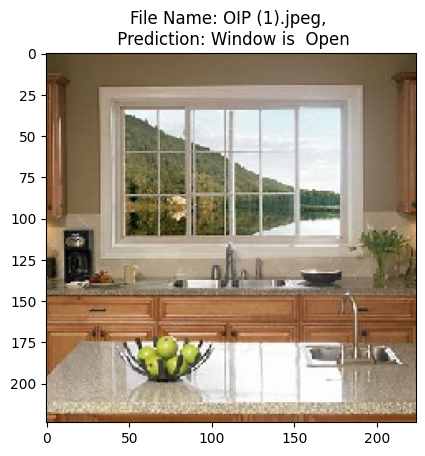

1/1 [==============================] - 0s 41ms/step
[[0.91662633]]
{'close': 0, 'open': 1}


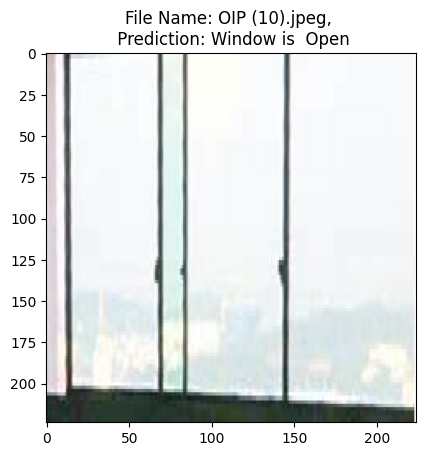

1/1 [==============================] - 0s 39ms/step
[[0.9978101]]
{'close': 0, 'open': 1}


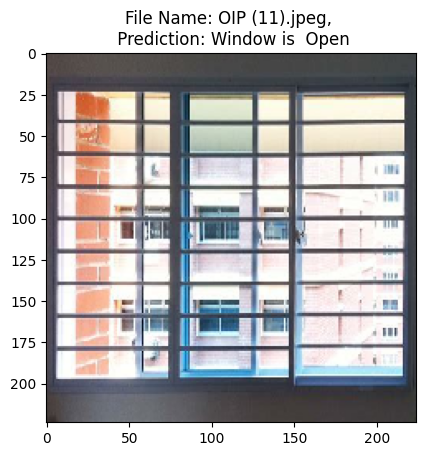

1/1 [==============================] - 0s 46ms/step
[[0.9060552]]
{'close': 0, 'open': 1}


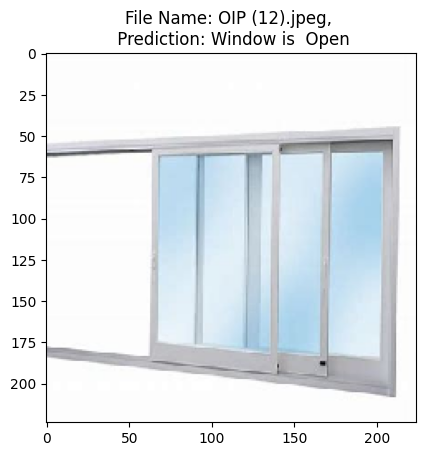

1/1 [==============================] - 0s 42ms/step
[[0.14568643]]
{'close': 0, 'open': 1}


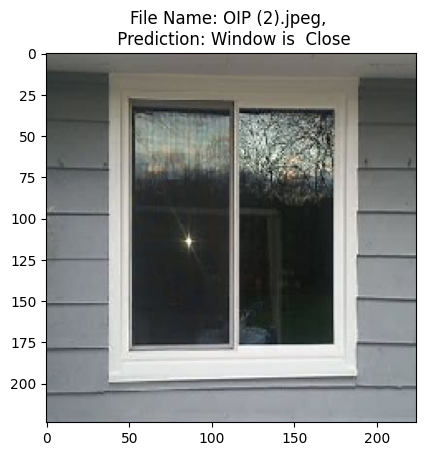

1/1 [==============================] - 0s 40ms/step
[[0.85337913]]
{'close': 0, 'open': 1}


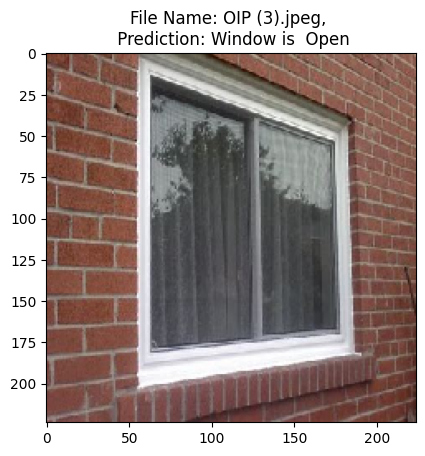

1/1 [==============================] - 0s 36ms/step
[[0.19728704]]
{'close': 0, 'open': 1}


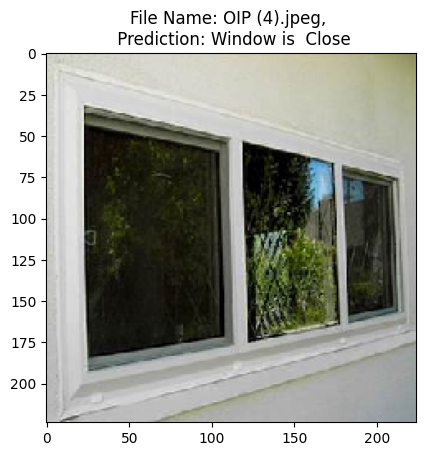

1/1 [==============================] - 0s 153ms/step
[[0.66572636]]
{'close': 0, 'open': 1}


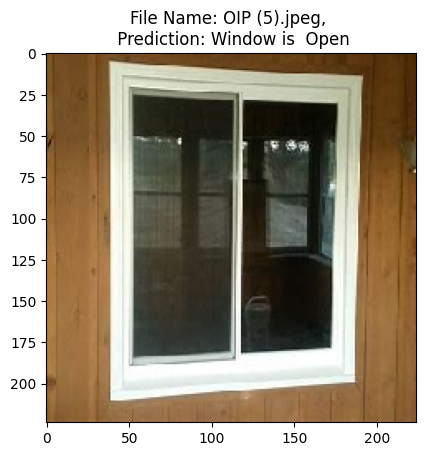

1/1 [==============================] - 0s 39ms/step
[[0.6753996]]
{'close': 0, 'open': 1}


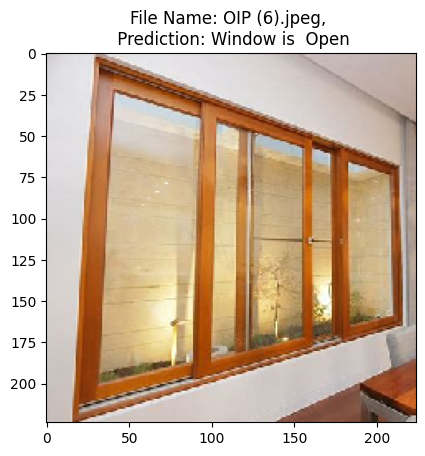

1/1 [==============================] - 0s 39ms/step
[[0.7286493]]
{'close': 0, 'open': 1}


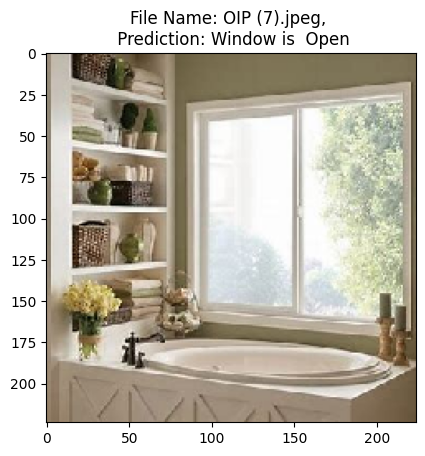

1/1 [==============================] - 0s 35ms/step
[[0.973797]]
{'close': 0, 'open': 1}


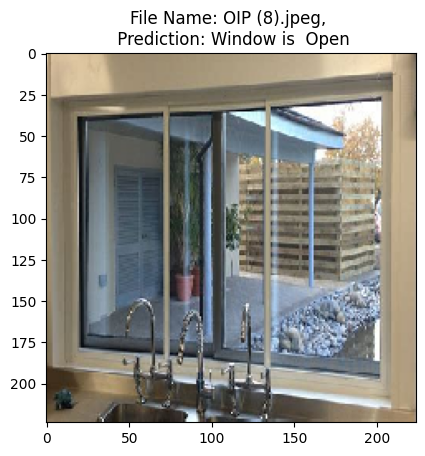

1/1 [==============================] - 0s 66ms/step
[[0.8393705]]
{'close': 0, 'open': 1}


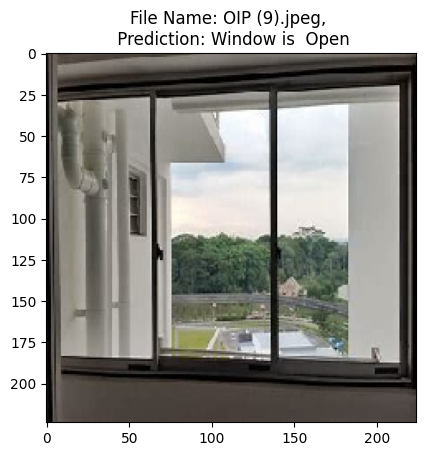

1/1 [==============================] - 0s 37ms/step
[[0.3509162]]
{'close': 0, 'open': 1}


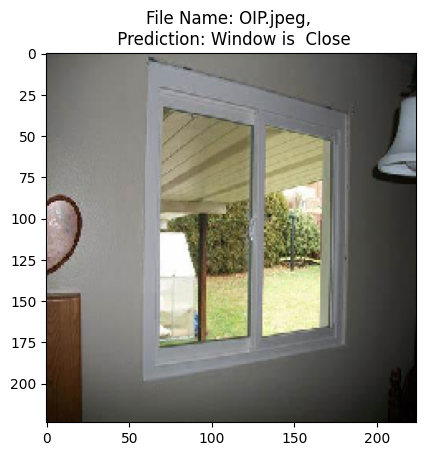

1/1 [==============================] - 0s 59ms/step
[[0.8936503]]
{'close': 0, 'open': 1}


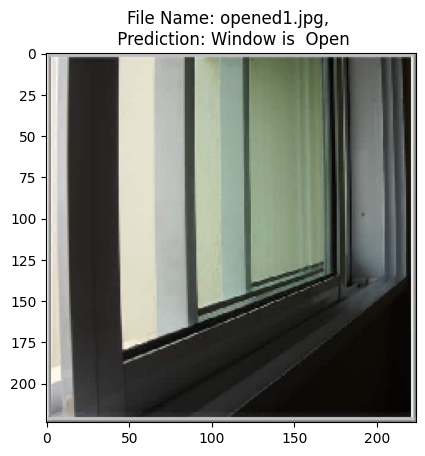

1/1 [==============================] - 0s 46ms/step
[[0.99422336]]
{'close': 0, 'open': 1}


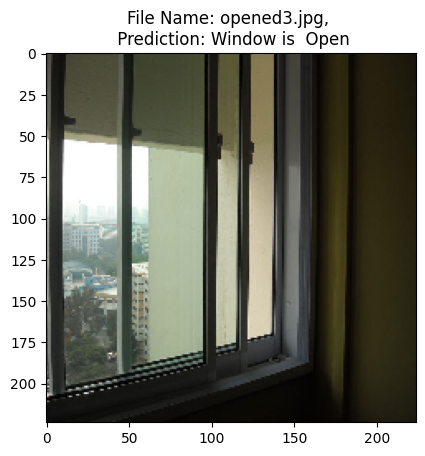

1/1 [==============================] - 0s 52ms/step
[[0.8093981]]
{'close': 0, 'open': 1}


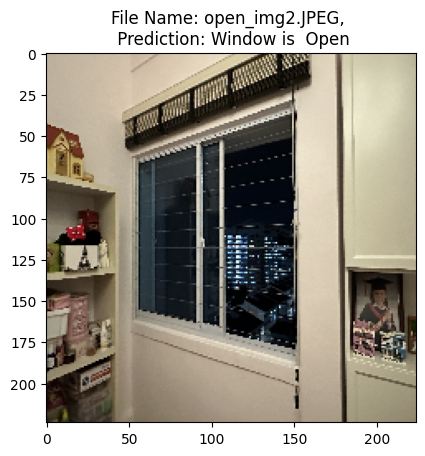

1/1 [==============================] - 0s 39ms/step
[[0.93978256]]
{'close': 0, 'open': 1}


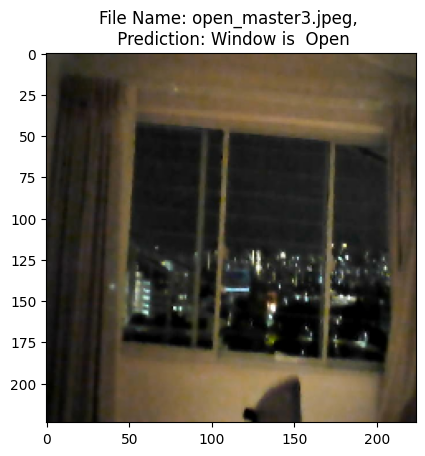

1/1 [==============================] - 0s 36ms/step
[[0.9220743]]
{'close': 0, 'open': 1}


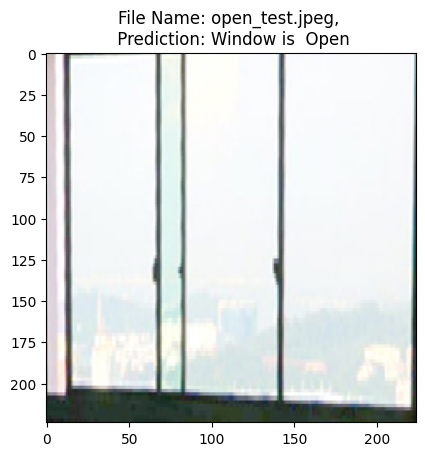

1/1 [==============================] - 0s 41ms/step
[[0.95076615]]
{'close': 0, 'open': 1}


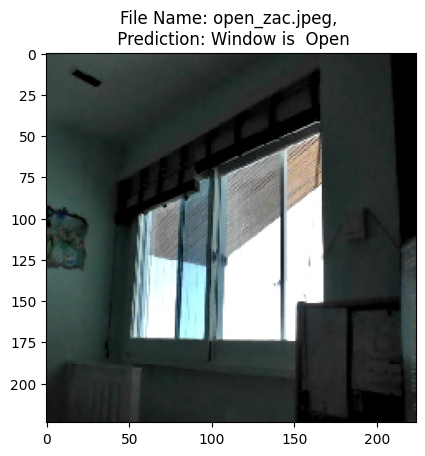

1/1 [==============================] - 0s 36ms/step
[[0.91032946]]
{'close': 0, 'open': 1}


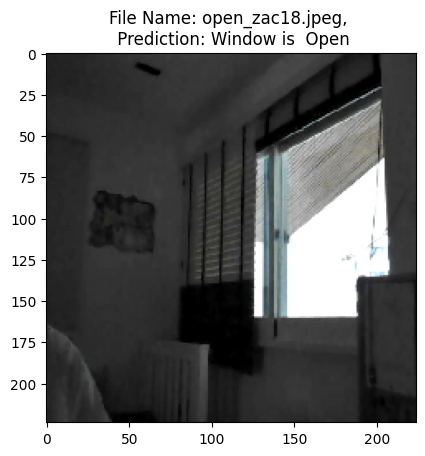

1/1 [==============================] - 0s 61ms/step
[[0.8629268]]
{'close': 0, 'open': 1}


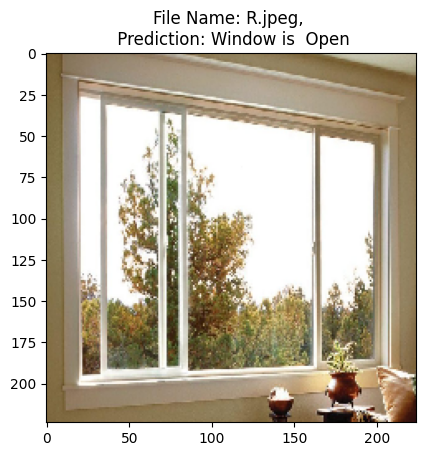

1/1 [==============================] - 0s 45ms/step
[[0.50012046]]
{'close': 0, 'open': 1}


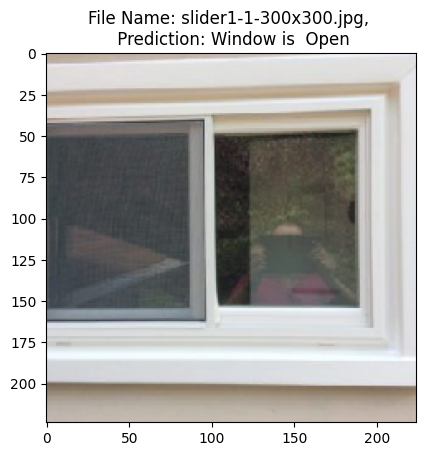

1/1 [==============================] - 0s 50ms/step
[[0.9977529]]
{'close': 0, 'open': 1}


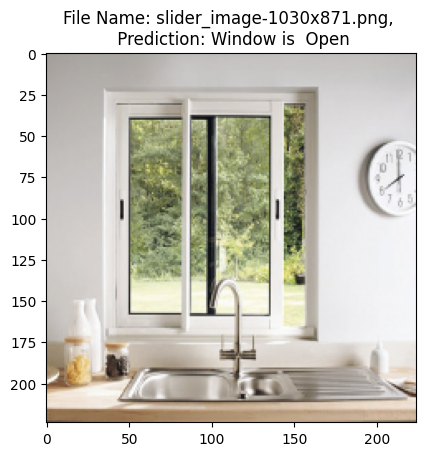

1/1 [==============================] - 0s 35ms/step
[[0.81819546]]
{'close': 0, 'open': 1}


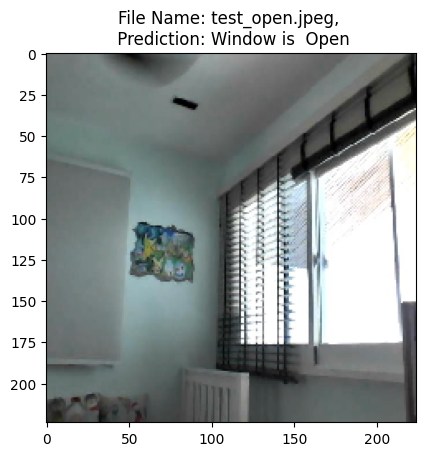

1/1 [==============================] - 0s 53ms/step
[[0.8968783]]
{'close': 0, 'open': 1}


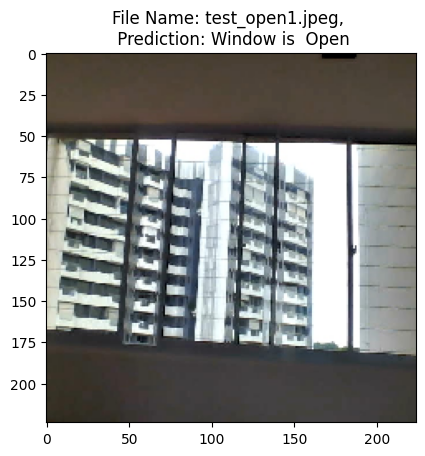

1/1 [==============================] - 0s 114ms/step
[[0.11293709]]
{'close': 0, 'open': 1}


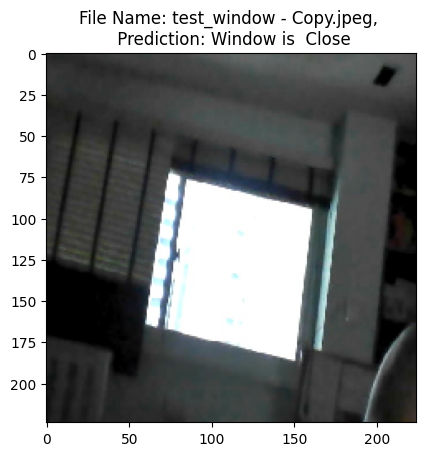

1/1 [==============================] - 0s 43ms/step
[[0.9685853]]
{'close': 0, 'open': 1}


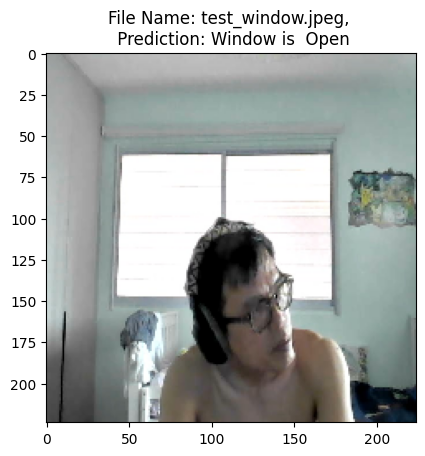

1/1 [==============================] - 0s 41ms/step
[[0.688116]]
{'close': 0, 'open': 1}


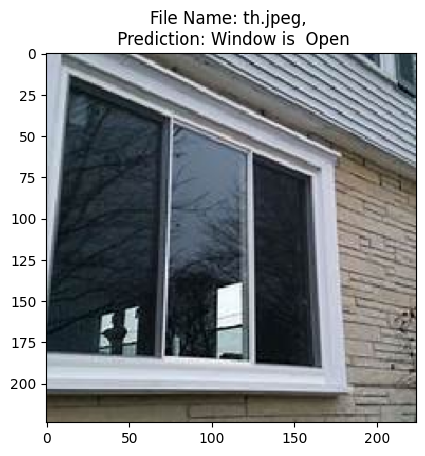

In [725]:
import os
filelist = os.listdir(TEST_DATA_DIR)
for file in filelist:
    img = image.load_img(os.path.join(TEST_DATA_DIR,file), target_size=(WIDTH,HEIGHT))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = expanded_img_array / 255.  # Preprocess the image
    prediction = model.predict(preprocessed_img)
    print(prediction)
    print(val_generator.class_indices)

    plt.title(f"File Name: {file}, \n Prediction: Window is  {'Close' if prediction < CLASS_THRESHOLD else 'Open'}")
    plt.imshow(img)
    plt.show()    